# EPOCH - Task 1

## <font color=blue>Importing Necessary Packages.</font>

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from shapely.geometry import Point
import geopandas as gpd

import os
from pathlib import Path
from copy import deepcopy

print('imported')

imported


## <font color=blue>1. Understanding and Preprocessing Data</font>

### 1.1. Understanding Data

In [2]:
#Filter Tamilnadu datapoints from dataset.
df = pd.read_csv('/content/clustering_data.csv')
tamilnadu_df = df[df['StateName'] == 'TAMIL NADU']
print(tamilnadu_df.shape)

#Check for duplicates.
tamilnadu_df = tamilnadu_df.drop_duplicates()
print(tamilnadu_df.shape)

#Check for missing data.
print(tamilnadu_df.isnull().sum())
print(tamilnadu_df)

(11795, 11)
(11795, 11)
CircleName       0
RegionName       0
DivisionName     0
OfficeName       0
Pincode          0
OfficeType       0
Delivery         0
District         0
StateName        0
Latitude        10
Longitude       10
dtype: int64
              CircleName                     RegionName  \
1733    Tamilnadu Circle  Central Region, Trichirapalli   
5428    Tamilnadu Circle            Chennai City Region   
5900    Tamilnadu Circle     Western Region, Coimbatore   
15612   Tamilnadu Circle            Chennai City Region   
52941   Tamilnadu Circle       Southern Region, Madurai   
...                  ...                            ...   
156933  Tamilnadu Circle  Central Region, Trichirapalli   
156934  Tamilnadu Circle  Central Region, Trichirapalli   
156972  Tamilnadu Circle  Central Region, Trichirapalli   
156973  Tamilnadu Circle  Central Region, Trichirapalli   
156993  Tamilnadu Circle     Western Region, Coimbatore   

                   DivisionName              

<ipython-input-2-cb42e8032c30>:2: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/clustering_data.csv')


The above dataframe seems to gives us data regarding the Post Office services, the types of offices: HO (Head Office), PO (Sub Office) and BO (Branch Office) and the delivery services available at differnet places, districts and regions.

*   There are 11795 datapoints with StateName as TamilNadu.
*   There are no duplicate datapoints.
*   There are 10 datapoints with coordinates data missing.





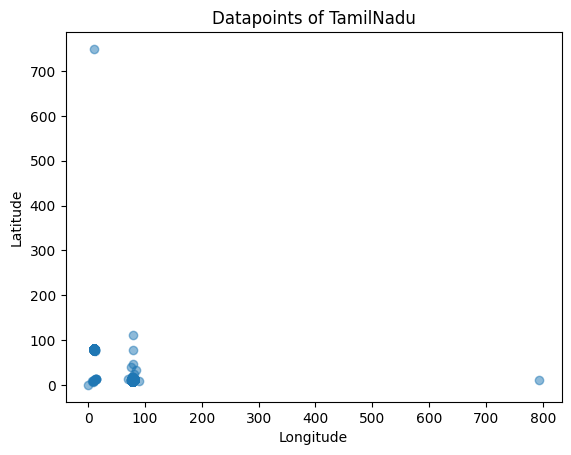

In [13]:
#Get the coordinates of datapoints to plot.
lat=tamilnadu_df["Latitude"]
lon=tamilnadu_df["Longitude"]
x=lon.tolist()
y=lat.tolist()
x=[float(i) for i in x]
y=[float(i) for i in y]

#Plot tamilnadu datapoints based on coordinates.
plt.title('Datapoints of TamilNadu')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.scatter(x, y, alpha=0.5)
plt.show()

There seem to be **several datapoints** in the dataset with **incorrect data**. <br>The longitude and langitude data are not in the range for a place in Tamil Nadu.




### 1.2. Filtering Data

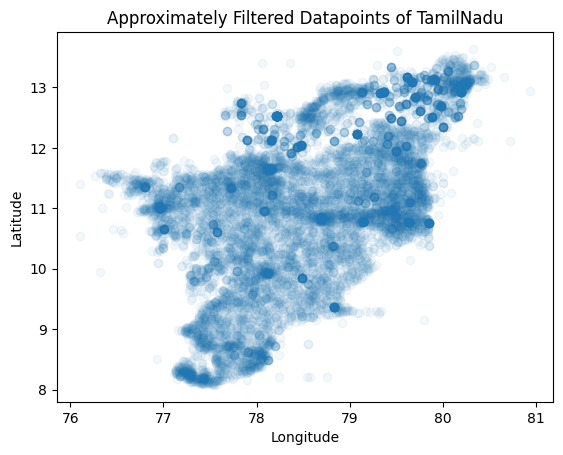

In [30]:
#Filter datapoints based on approx. range of correct coordinates.
p_x=[]
p_y=[]
for i in range(len(x)):
  if(x[i]>76 and y[i]<15 and x[i]<82 and y[i]>5):
    p_x.append(x[i])
    p_y.append(y[i])

#Plot tamilnadu datapoints based on coordinates.
plt.title('Approximately Filtered Datapoints of TamilNadu')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.scatter(p_x, p_y, alpha=0.05)
plt.show()

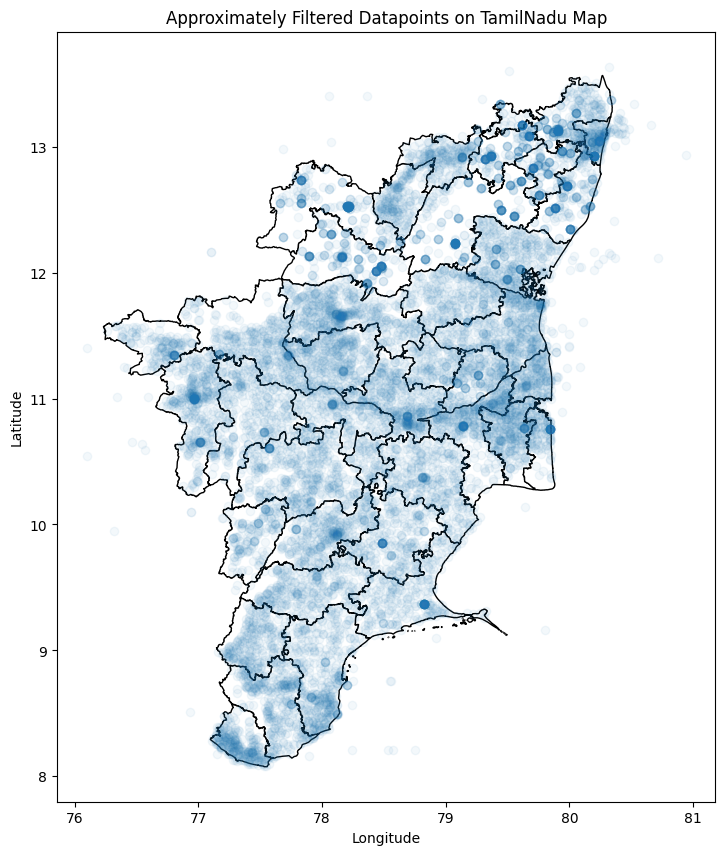

In [31]:
#Plot approximately filtered datapoints along with Tamilnadu map.

# Import and read tamilnadu's shapefile.
shapefile_path='/content/TAMIL NADU_DISTRICTS.shp'
tamilnadu = gpd.read_file(shapefile_path)

# Plot map + coordinates.
fig, ax = plt.subplots(figsize=(10, 10))
plt.title('Approximately Filtered Datapoints on TamilNadu Map')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
tamilnadu.plot(ax=ax, color='white', edgecolor='black')
plt.scatter(p_x,p_y,alpha=0.05)
plt.show()


Points have been filtered using a rough range. However on plotting the map as well it is noticed that there are still **points outside the border to be removed**.

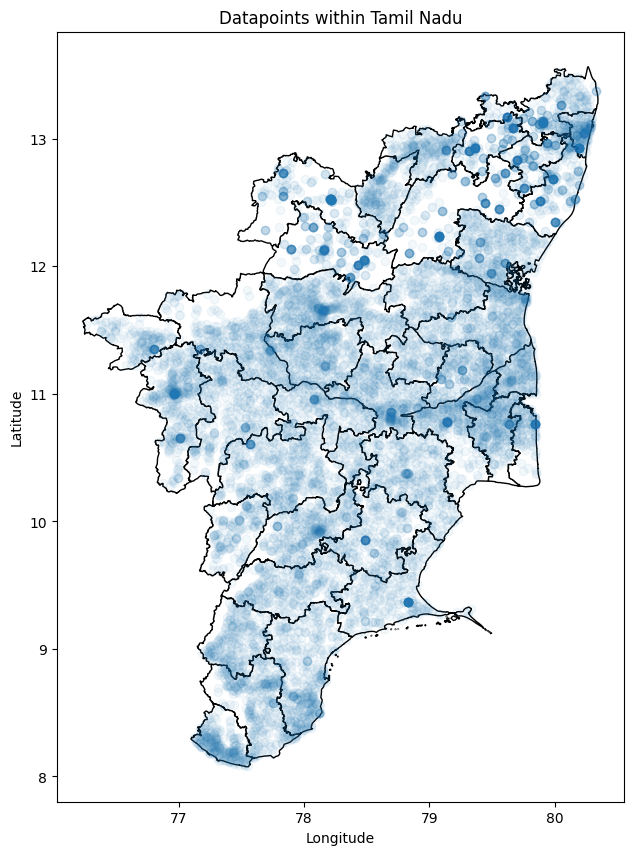

In [32]:
#Filter entire data based on Tamilnadu map border.

# Load entire data.
df = tamilnadu_df

# Convert DataFrame to GeoDataFrame
geometry = [Point(xy) for xy in zip(df['Longitude'], df['Latitude'])]
geo_df = gpd.GeoDataFrame(df, geometry=geometry)

# Ensure both GeoDataFrames use the same coordinate reference system (CRS)
tamilnadu = tamilnadu.to_crs(epsg=4326)
geo_df = geo_df.set_crs(epsg=4326)

# Filter points within the boundary of Tamil Nadu
filtered_tamilnadu_df = geo_df[geo_df.geometry.within(tamilnadu.unary_union)]

# Plot the coordinates of the filtered datapoints.
p_x = filtered_tamilnadu_df['Longitude'].tolist()
p_y = filtered_tamilnadu_df['Latitude'].tolist()

p_x=[float(i) for i in p_x]
p_y=[float(i) for i in p_y]

fig, ax = plt.subplots(figsize=(8, 10))
tamilnadu.plot(ax=ax, color='white', edgecolor='black')
plt.scatter(p_x, p_y,alpha=0.05)

plt.title('Datapoints within Tamil Nadu')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()


In [33]:
#Array containing all coordinates.
coords = np.array(list(zip(p_x, p_y)))
print(len(coords))

11227


Out of the total 11795 datapoints under Tamil Nadu state:
*   11227 correct points selected.
*   568 points have been removed, of which **558 are incorrect data**, and **10 are data with missing coordinate values**.


*For Tamilnadu shapefile, refer **1**.*

## <font color=blue>2. Clustering Analysis</font>

### 2.1. Finding Optimal Value of k for k-Clustering

In [18]:
#Defining euclidean distance function.
def distance(a, b):
  one = (a[0] - b[0]) ** 2
  two = (a[1] - b[1]) ** 2
  distance = (one+two) ** 0.5
  return distance

Using the **Elbow Method** to find optimal value of k.

In [19]:
#Function to calculate SSE(Sum of Squared Errors) and hence, the WSE (Within-Cluster-Sum of Squared Errors) score for a given k value to detrmine optimal k value.
def calculate_wse(k):
  sse=0

  #Random initialization of k centroids.
  centroids_x = np.random.uniform(min(p_x), max(p_x), size=k)
  centroids_y = np.random.uniform(min(p_y), max(p_y), size=k)

  centroids = np.array(list(zip(centroids_x, centroids_y)))

  # Intitate 'centroids_old' to store previous epoch's centroids during updating of centroids.
  centroids_old = np.zeros(centroids.shape)

  # Initialize labels and distances arrays to hold respective values required to update centroids.
  labels = np.zeros(len(p_x))
  distances = np.zeros(k)

  # Initialize error array contain distance between centroids before and after array.
  # Note: centroids_old is all zeros currently.
  error = np.zeros(k)
  for i in range(k):
    error[i] = distance(centroids[i], centroids_old[i])

  # While loop for convergence of centroids.
  # Editting centroids until error is 0, i.e, centroids_old = centroids, when convergence is attained.
  while error.all() != 0:

    # Assigning samples to nearest centroid.
    for i in range(len(p_x)):
      for j in range(k):
        distances[j] = distance(coords[i], centroids[j])
      cluster = np.argmin(distances)
      labels[i] = cluster

    # Remember old centroids before updating.
    centroids_old = deepcopy(centroids)

    # Update centroids to mean point of points labeled under the centroid.
    for i in range(k):
      points = [coords[j] for j in range(len(coords)) if labels[j] == i]
      centroids[i] = np.mean(points, axis=0)

    # Calculate error between old centroids and updated centroids.
    for i in range(k):
      error[i] = distance(centroids[i], centroids_old[i])

  #Calculating SSE for final k centroids.
  for i in range(k):
    points = np.array([coords[j] for j in range(len(p_x)) if labels[j] == i])
    for point in points:
      sse+=(point[0] - centroids[i][0]) ** 2 + (point[1] - centroids[i][1]) ** 2

  return sse

2
3
4
5
6
7
8


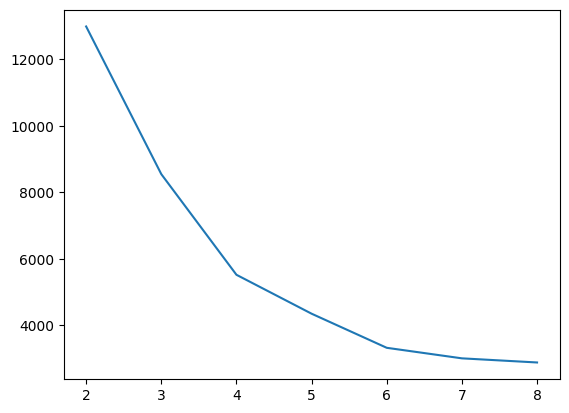

In [ ]:
#Getting the list of SSE and hence the WSE (Within-Cluster-Sum of Squared Errors) score values corresponding to k values from 2 to 8.
wse=[]
k_values=list(range(2,9))
for i in k_values:
  wse.append(calculate_wse(i))
  print(i)

#Plotting WSE vs. k.
plt.plot(k_values,wse)
plt.show()

Using the **Elbow method** (that is, the point at which the above graph seems to form an elbow at), we have found the optimal value of k for k means clustering as **k=4**.

*Note: There are other methods like the Silhouette method to find optimal value of k. The value k=4 has been cross-checked with the Silhouette method and has proved to be optimal.*

In [ ]:
# Function to calculate Silhouette value.
# Note: the below function is very slow and hence, has not been used.

def calculate_sil(k):
  total_sil=0

  centroids_x = np.random.uniform(min(p_x), max(p_x), size=k)
  centroids_y = np.random.uniform(min(p_y), max(p_y), size=k)

  centroids = np.array(list(zip(centroids_x, centroids_y)))

  centroids_old = np.zeros(centroids.shape)


  labels = np.zeros(len(p_x))
  distances = np.zeros(k)

  error = np.zeros(k)

  for i in range(k):
    error[i] = distance(centroids[i], centroids_old[i])


  while error.all() != 0:

    for i in range(len(p_x)):
      for j in range(k):
        distances[j] = distance(coords[i], centroids[j])
      cluster = np.argmin(distances)
      labels[i] = cluster

    centroids_old = deepcopy(centroids)

    for i in range(k):
      points = [coords[j] for j in range(len(coords)) if labels[j] == i]
      centroids[i] = np.mean(points, axis=0)

    for i in range(k):
      error[i] = distance(centroids[i], centroids_old[i])


  for i in range(k):
    points = np.array([coords[j] for j in range(len(p_x)) if labels[j] == i])
    if(len(points)==1):
      total_sil+=0
    else:
      for point in points:
        bl=[]
        a=0
        for p2 in points:
          a+=distance(point, p2)
        a/=(len(points)-1)

        for n in range(k):
          b_current=0
          n_points = np.array([coords[j] for j in range(len(p_x)) if labels[j] == n and labels[j]!=i])
          if(len(n_points)!=0):
            for p in n_points:
              b_current+=distance(point,p)
            b_current/=(len(n_points))
            bl.append(b_current)

        b=np.min(bl)
        total_sil+=((b-a)/(max(b,a)))

  sil=total_sil/len(p_x)

  return sil

### 2.2. Implementing k-clustering with Optimal Value Of k=4

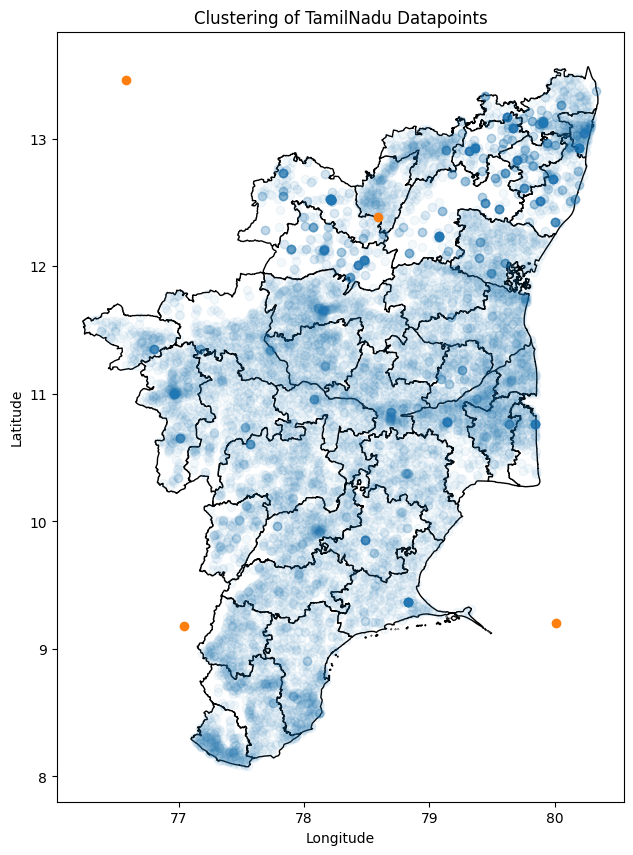

In [34]:
#Clustering of datapoints into 4.
k=4

# Randomly initiate k=4 centroids.
centroids_x = np.random.uniform(min(p_x), max(p_x), size=k)
centroids_y = np.random.uniform(min(p_y), max(p_y), size=k)

centroids = np.array(list(zip(centroids_x, centroids_y)))

#Plot map, coordinates along with k=4 centroids.
fig, ax = plt.subplots(figsize=(8, 10))
tamilnadu.plot(ax=ax, color='white', edgecolor='black')

plt.title('Clustering of TamilNadu Datapoints')
plt.scatter(p_x, p_y, alpha=0.05)
plt.scatter(centroids_x, centroids_y)

plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

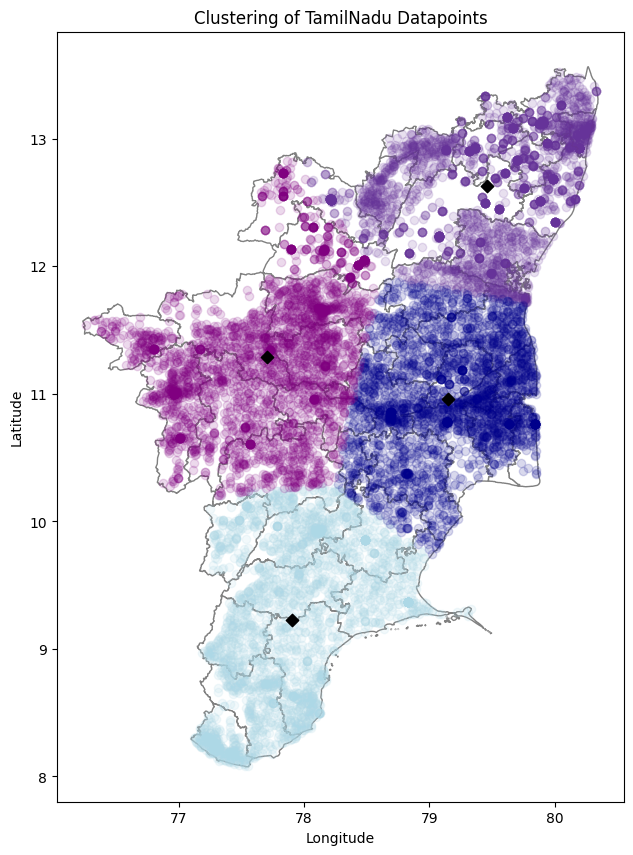

In [35]:
# Algorithm for convergence of centroids.

# Intitate 'centroids_old' to store previous epoch's centroids during updating of centroids.
centroids_old = np.zeros(centroids.shape)

# Initialize labels and distances arrays to hold respective values required to update centroids.
labels = np.zeros(len(p_x))
distances = np.zeros(k)

# Initialize error array contain distance between centroids before and after array.
# Note: centroids_old is all zeros currently.
error = np.zeros(k)
for i in range(k):
  error[i] = distance(centroids[i], centroids_old[i])

# While loop for convergence of centroids.
# Editting centroids until error is 0, i.e, centroids_old = centroids, when convergence is attained.
while error.all() != 0:

  # Assign samples to nearest centroid.
  for i in range(len(p_x)):
    for j in range(k):
      distances[j] = distance(coords[i], centroids[j])
    cluster = np.argmin(distances)
    labels[i] = cluster

  # Remember old centroids before updating.
  centroids_old = deepcopy(centroids)

  # Update centroids to mean point of points labeled under the centroid.
  for i in range(k):
    points = [coords[j] for j in range(len(coords)) if labels[j] == i]
    centroids[i] = np.mean(points, axis=0)

  # Calculate error between old centroids and updated centroids.
  for i in range(k):
    error[i] = distance(centroids[i], centroids_old[i])


# Plot final centroids and corresponding point labels + map.
fig, ax = plt.subplots(figsize=(8, 10))
tamilnadu.plot(ax=ax, color='white', edgecolor='grey')

plt.title('Clustering of TamilNadu Datapoints')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

colors = ['rebeccapurple', 'lightblue', 'darkblue', 'purple', 'mediumorchid', 'darkorchid', 'lightskyblue','rebeccapurple','mediumslateblue']

for i in range(k):
  points = np.array([coords[j] for j in range(len(p_x)) if labels[j] == i])
  plt.scatter(points[:, 0], points[:, 1], c=colors[i], alpha=0.15)

plt.scatter(centroids[:, 0], centroids[:, 1], marker='D', s=40, color='black')

plt.show()


Successfully, have clustered data into 4 clusters using k-clustering algorithm.

## <font color=blue>3. Inference and Insights</font>

### 3.1. Analysing Districts And Division Names

In [ ]:
# Convert division and district data into lists.
division=filtered_tamilnadu_df['DivisionName'].tolist()
district=filtered_tamilnadu_df['District'].tolist()

In [ ]:
# Compare data available before and after filtering.
print('The number of divisions the initial dataset was categorized into: ', len(np.unique(tamilnadu_df['DivisionName'])))
print('The number of divisions the filtered dataset is categorized into: ', len(np.unique(division)))
print('\n')
print('The number of districts the initial dataset was categorized into: ', len(np.unique(tamilnadu_df['District'])))
print('The number of districts the filtered dataset is categorized into: ', len(np.unique(district)))

The number of divisions the initial dataset was categorized into:  45
The number of divisions the filtered dataset is categorized into:  45


The number of districts the initial dataset was categorized into:  38
The number of districts the filtered dataset is categorized into:  38


The division and district names from the data are all places from Tamil Nadu. The incorrect datapoints also had names from Tamil Nadu. This leads us to believe there were several points that when plotted where outside the map but still represent points from within Tamilnadu. <br>
**There existed several datapoints from within TamilNadu with incorrect coordinates.**

### 3.2. Analysing Pincodes

In [54]:
# Convert pincode data into a list.
pin=filtered_tamilnadu_df['Pincode'].tolist()
pin=[float(i) for i in pin]

unique_pin=np.unique(pin)

print(f'The total number of datapoints: {len(pin)}')
print(f'The number of unique pincodes: {len(unique_pin)}')

The total number of datapoints: 11227
The number of unique pincodes: 2014


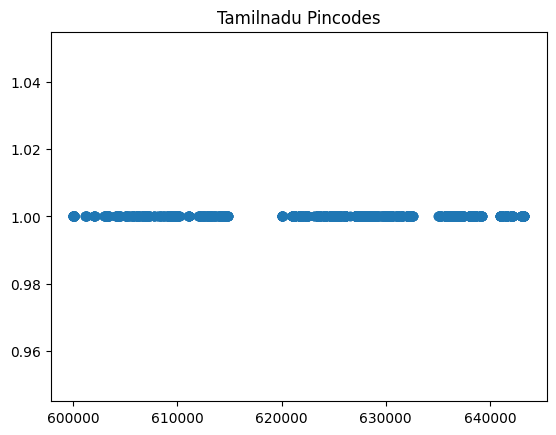

In [ ]:
# Plot the unique pincodes to understand the range.
plt.scatter(unique_pin,np.ones(2014))
plt.title('Tamilnadu Pincodes')
plt.show()

Approximately 3 and more specifically, 4 ranges of pincodes have been observed in Tamilnadu. Let us plot them to see the regions they occupy.

Total points: 11227


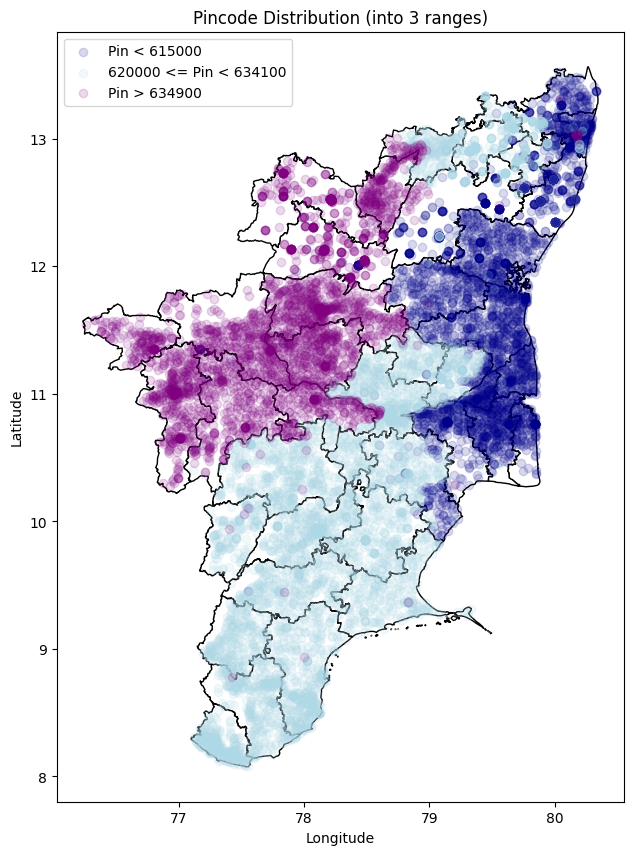

Total points: 11227


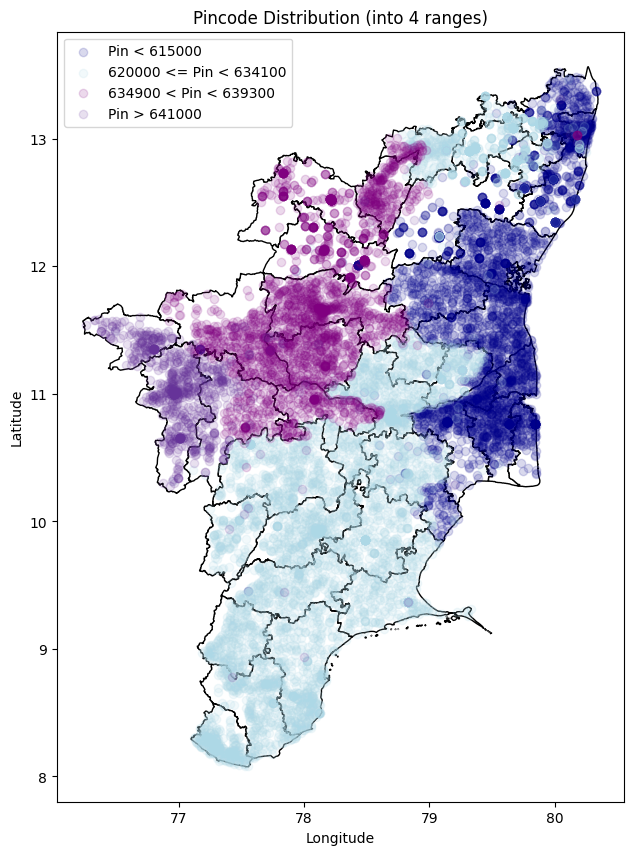

In [55]:
# Plot pincodes divided in 3 value ranges.
fig, ax = plt.subplots(figsize=(8, 10))
tamilnadu.plot(ax=ax, color='white', edgecolor='black')

x_1=[p_x[i] for i in range(len(p_x)) if pin[i]<615000]
y_1=[p_y[i] for i in range(len(p_y)) if pin[i]<615000]

x_2=[p_x[i] for i in range(len(p_x)) if pin[i]<634100 and pin[i]>=620000]
y_2=[p_y[i] for i in range(len(p_y)) if pin[i]<634100 and pin[i]>=620000]

x_3=[p_x[i] for i in range(len(p_x)) if pin[i]>634900]
y_3=[p_y[i] for i in range(len(p_y)) if pin[i]>634900]

print(f'Total points: {len(x_1)+len(x_2)+len(x_3)}')

plt.scatter(x_1,y_1,alpha=0.15, color='darkblue', label='Pin < 615000')
plt.scatter(x_2,y_2,alpha=0.15, color='lightblue', label='620000 <= Pin < 634100')
plt.scatter(x_3,y_3,alpha=0.15, color='purple', label='Pin > 634900')

plt.legend()
plt.title('Pincode Distribution (into 3 ranges)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

# Plot pincodes divided in 4 value ranges.
fig, ax = plt.subplots(figsize=(8, 10))
tamilnadu.plot(ax=ax, color='white', edgecolor='black')

x_1=[p_x[i] for i in range(len(p_x)) if pin[i]<615000]
y_1=[p_y[i] for i in range(len(p_y)) if pin[i]<615000]

x_2=[p_x[i] for i in range(len(p_x)) if pin[i]<634100 and pin[i]>=620000]
y_2=[p_y[i] for i in range(len(p_y)) if pin[i]<634100 and pin[i]>=620000]

x_3=[p_x[i] for i in range(len(p_x)) if pin[i]>634900 and pin[i]<639300]
y_3=[p_y[i] for i in range(len(p_y)) if pin[i]>634900 and pin[i]<639300]

x_4=[p_x[i] for i in range(len(p_x)) if pin[i]>641000]
y_4=[p_y[i] for i in range(len(p_y)) if pin[i]>641000]

print(f'Total points: {len(x_1)+len(x_2)+len(x_3)+len(x_4)}')

plt.scatter(x_1,y_1,alpha=0.15, color='darkblue', label='Pin < 615000')
plt.scatter(x_2,y_2,alpha=0.15, color='lightblue', label='620000 <= Pin < 634100')
plt.scatter(x_3,y_3,alpha=0.15, color='purple', label='634900 < Pin < 639300')
plt.scatter(x_4,y_4,alpha=0.15, color='rebeccapurple', label='Pin > 641000')

plt.legend()
plt.title('Pincode Distribution (into 4 ranges)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

The above maps give us insight into how pincodes are distributed in TamilNadu and what areas a given value range of pincodes represent.
*   Upto 615000 - North-East Region (close to border).
*   From 620000 to 634100 - South Region and some parts of Centre.
*   From 634900 to 639300 - North-West Region.
*   From 641000 - West border.





### 3.3. Analysing Regions

In [43]:
# Convert region data into list.
region=filtered_tamilnadu_df['RegionName'].tolist()

# Compare data available before and after filtering.
print('The number of regions the initial dataset was categorized into: ', len(np.unique(tamilnadu_df['RegionName'])))
print('The number of regions the filtered dataset is categorized into: ', len(np.unique(region)))
print('\n')

# Print all the region categories.
print(f'The regions of TamilNadu: {np.unique(region)}')

The number of regions the initial dataset was categorized into:  4
The number of regions the filtered dataset is categorized into:  4


The regions of TamilNadu: ['Central Region, Trichirapalli' 'Chennai City Region'
 'Southern Region, Madurai' 'Western Region, Coimbatore']


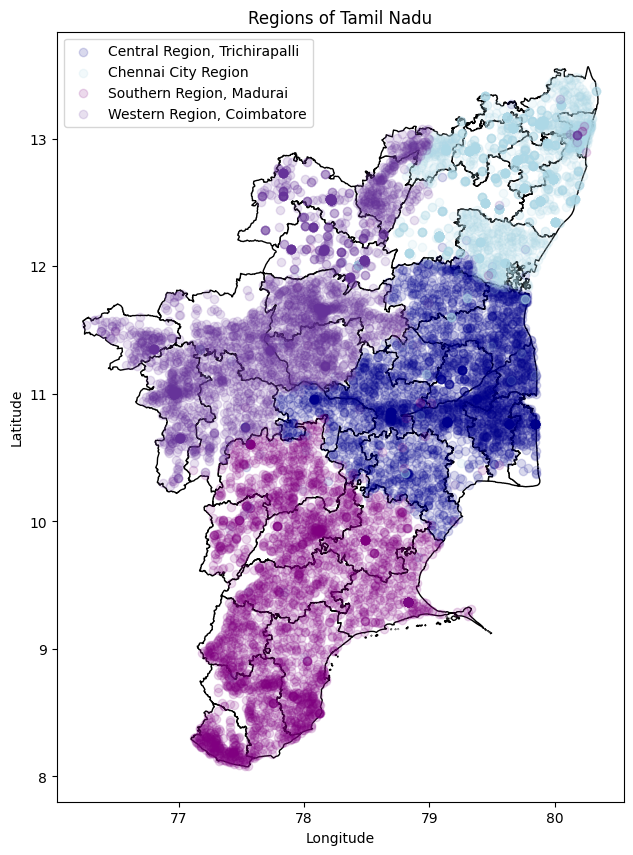

In [46]:
# Plot the datapoints according to the region they belong to.
fig, ax = plt.subplots(figsize=(8, 10))
tamilnadu.plot(ax=ax, color='white', edgecolor='black')

x_1=[p_x[i] for i in range(len(p_x)) if region[i]=='Central Region, Trichirapalli']
y_1=[p_y[i] for i in range(len(p_y)) if region[i]=='Central Region, Trichirapalli']

x_2=[p_x[i] for i in range(len(p_x)) if region[i]=='Chennai City Region']
y_2=[p_y[i] for i in range(len(p_y)) if region[i]=='Chennai City Region']

x_3=[p_x[i] for i in range(len(p_x)) if region[i]=='Southern Region, Madurai']
y_3=[p_y[i] for i in range(len(p_y)) if region[i]=='Southern Region, Madurai']

x_4=[p_x[i] for i in range(len(p_x)) if region[i]=='Western Region, Coimbatore']
y_4=[p_y[i] for i in range(len(p_y)) if region[i]=='Western Region, Coimbatore']


plt.scatter(x_1,y_1,alpha=0.15, color='darkblue', label='Central Region, Trichirapalli')
plt.scatter(x_2,y_2,alpha=0.15, color='lightblue', label='Chennai City Region')
plt.scatter(x_3,y_3,alpha=0.15, color='purple', label='Southern Region, Madurai')
plt.scatter(x_4,y_4,alpha=0.15, color='rebeccapurple', label='Western Region, Coimbatore')

plt.legend()

plt.title('Regions of Tamil Nadu')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

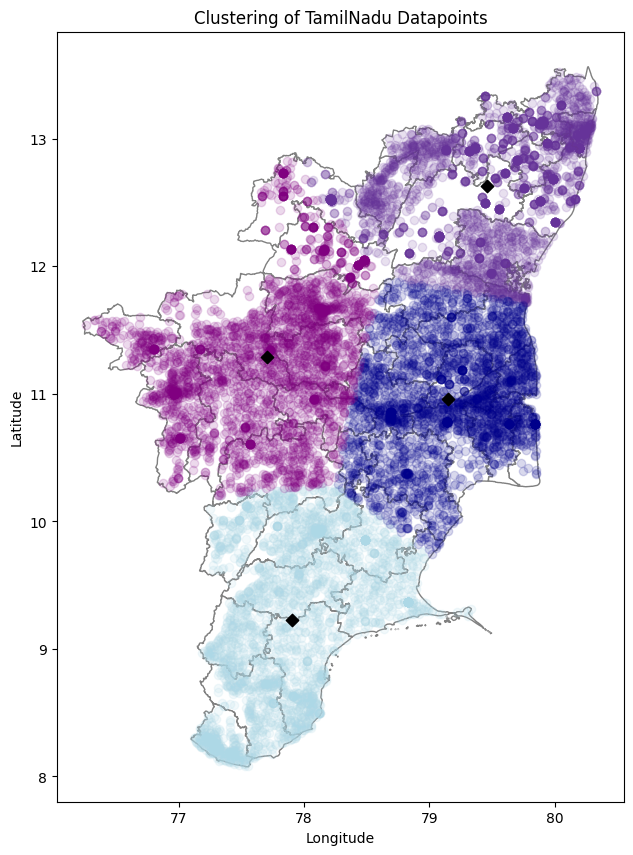

In [36]:
# Plot the 4 clusters from earlier (formed using k-clustering algorithm).
fig, ax = plt.subplots(figsize=(8, 10))
tamilnadu.plot(ax=ax, color='white', edgecolor='grey')

plt.title('Clustering of TamilNadu Datapoints')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

colors = ['rebeccapurple', 'lightblue', 'darkblue', 'purple', 'mediumorchid', 'darkorchid', 'lightskyblue','rebeccapurple','mediumslateblue']

for i in range(k):
  points = np.array([coords[j] for j in range(len(p_x)) if labels[j] == i])
  plt.scatter(points[:, 0], points[:, 1], c=colors[i], alpha=0.15)

plt.scatter(centroids[:, 0], centroids[:, 1], marker='D', s=40, color='black')

plt.show()

**On observing, we can see that the 4 clusters obtained from k-clustering algorithm is very similar to the 4 clusters formed when data is plotted based on regions of Tamilnadu. This indicates the significance of the clusters formed earlier.**

***Four Clusters of k-clustering ≈ Four Regions of TamilNadu***



### 3.4 Analysing Office And Office Types

In [37]:
# Convert office name and office type data into lists.
office=delivery=filtered_tamilnadu_df['OfficeName'].tolist()
officetype=filtered_tamilnadu_df['OfficeType'].tolist()

# Compare data available before and after filtering.
print('The number of offices the initial dataset was categorized into: ', len(np.unique(tamilnadu_df['OfficeName'])))
print('The number of offices the filtered dataset is categorized into: ', len(np.unique(office)))
print('\n')
print('Office names that were filtered out/removed:')
print([i for i in np.unique(tamilnadu_df['OfficeName']) if i not in np.unique(office)])
print('\n')
# Understand types of offices.
print('The office types are: ', np.unique(officetype))
ho_count=officetype.count('HO')
po_count=officetype.count('PO')
bo_count=officetype.count('BO')
print('The number of offices of each office type before filtering:')
print('HO: ',(tamilnadu_df['OfficeType'].tolist()).count('HO'))
print('PO: ',(tamilnadu_df['OfficeType'].tolist()).count('PO'))
print('BO: ',(tamilnadu_df['OfficeType'].tolist()).count('BO'))
print('The number of offices of each office type after filtering:')
print(f'HO: {ho_count}')
print(f'PO: {po_count}')
print(f'BO: {bo_count}')

The number of offices the initial dataset was categorized into:  11053
The number of offices the filtered dataset is categorized into:  10536


Office names that were filtered out/removed:
['19 Pudur BO', 'A.Kuravankuppam B.O', 'Ac.School B.O', 'Adaikalapuram S.O', 'Adaikkakuzhi B.O', 'Adambai B.O', 'Adambakkam S.O', 'Adirampattinam R.S B.O', 'Agasthiampalli B.O', 'Aingalipalayam BO', 'Akkachikuppam BO', 'Akkaraivattam B.O', 'Alagesapuram S.O', 'Alagiyanayakipuram B.O', 'Alampallam B.O', 'Alampara B.O', 'Alangadu B.O', 'Alangadu Uppur B.O', 'Alinjivakkam BO', 'Ambalapattu B.O', 'Ambalapattu North B.O', 'Aminjikarai S.O', 'Ammaiyandi B.O', 'Ammanichatram B.O', 'Ammeri B.O', 'Anaikadu B.O', 'Anandapuram S.O (Tuticorin)', 'Andami B.O', 'Andikadu B.O', 'Anna Nagar East S.O', 'Anna Nagar Western Extn S.O', 'Annapettai B.O', 'Arakottai B.O', 'Arasadikkuppam B.O', 'Arasanagaripattinam B.O', 'Aravenu S.O', 'Ariyakoshti B.O', 'Ariyalur B.O', 'Arkattuthurai B.O', 'Arukani B.O', 'Arumbakkam North

The removal of offices that belong to Tamilnadu in the filtered dataset adds as another point leading us to believe that there were several points that when plotted where outside the map but still represent points from within Tamilnadu. That is, <br>
**There existed several datapoints from within TamilNadu with incorrect coordinates.**

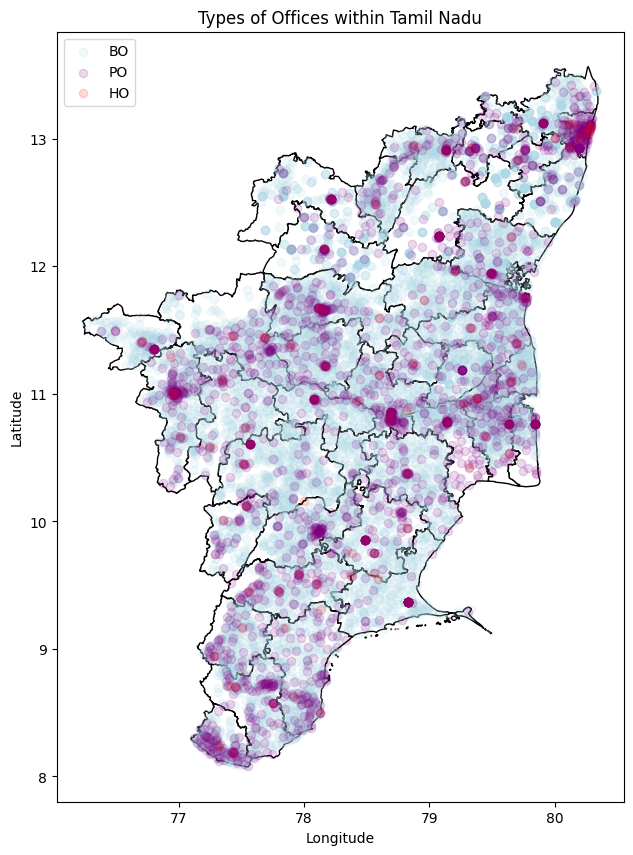

In [48]:
# Plot the ditribution of office types.
fig, ax = plt.subplots(figsize=(8, 10))
tamilnadu.plot(ax=ax, color='white', edgecolor='black')

x_bo=[p_x[i] for i in range(len(p_x)) if officetype[i]=='BO']
y_bo=[p_y[i] for i in range(len(p_y)) if officetype[i]=='BO']

x_ho=[p_x[i] for i in range(len(p_x)) if officetype[i]=='HO']
y_ho=[p_y[i] for i in range(len(p_y)) if officetype[i]=='HO']

x_po=[p_x[i] for i in range(len(p_x)) if officetype[i]=='PO']
y_po=[p_y[i] for i in range(len(p_y)) if officetype[i]=='PO']


plt.scatter(x_bo,y_bo,alpha=0.15, color='lightblue', label='BO')
plt.scatter(x_po,y_po,alpha=0.15, color='purple', label='PO')
plt.scatter(x_ho,y_ho,alpha=0.15, color='red', label='HO')

plt.legend()
plt.title('Types of Offices within Tamil Nadu')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

The offices are majorly of type BO (branch offices), minorly of type PO (post offices), and scatteringly little of type HO (Head offices), as expected. Our hypothesis regarding the offices representing the post services is reassured with this observation, as Branch offices are many, Sub offices, few, and Head offices, very few. <br><br>
Another thing to note, the number of offices of each of the type match the numbers of actual statistics of post services offices.

Number of HO offices in data: 92
<br>Number of Head Post offices in TamilNadu: 94

Number of PO offices in data: 2374
<br>Number of Sub Post offices in TamilNadu: 2504

Number of BO offices in data: 8761
<br>Number of Branch Post offices in TamilNadu: 9267

<br> *Note: Several offices were filtered out and others might be missing from the data, leading to the slight difference in numbers.*



*For further details regarding post services offices, refer **2**.*

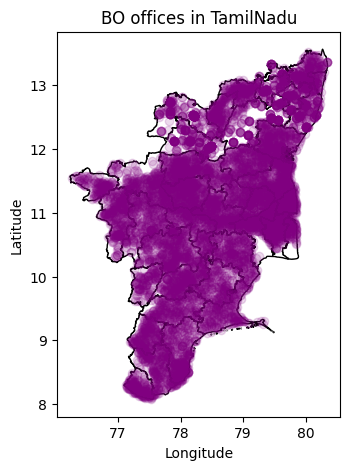

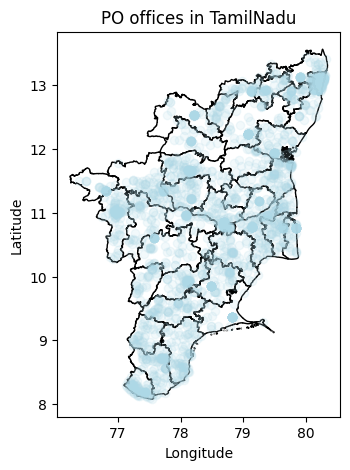

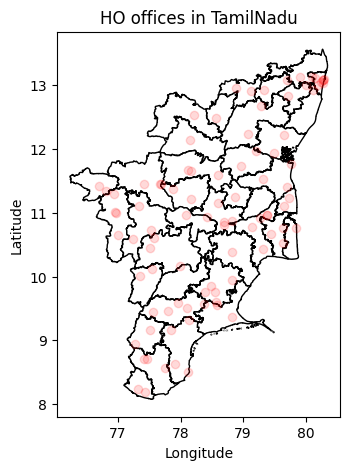

In [39]:
# Plot the distribution of offices of various types in separate maps.
fig, ax = plt.subplots(figsize=(4, 5))
tamilnadu.plot(ax=ax, color='white', edgecolor='black')
plt.scatter(x_bo,y_bo,alpha=0.15, color='purple')
plt.title('BO offices in TamilNadu')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

fig, ax = plt.subplots(figsize=(4, 5))
tamilnadu.plot(ax=ax, color='white', edgecolor='black')
plt.scatter(x_po,y_po,alpha=0.15, color='lightblue')
plt.title('PO offices in TamilNadu')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

fig, ax = plt.subplots(figsize=(4, 5))
tamilnadu.plot(ax=ax, color='white', edgecolor='black')
plt.scatter(x_ho,y_ho,alpha=0.15, color='red')
plt.title('HO offices in TamilNadu')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


We can observe that the density of PO and HO offices is very high near the north, that is around Chennai. Chennai being the capital of the state explains this.

### 3.5. Analysing Delivery Services

In [51]:
# Convert delivery data into list.
delivery=filtered_tamilnadu_df['Delivery'].tolist()

# Print count of delivery and non-delivery.
del_count = delivery.count('Delivery')
nondel_count = delivery.count('Non Delivery')

print(f'Number of places with availability of delivery services: {del_count}')
print(f'Number of places with non-availability of delivery services: {nondel_count}')

Number of places with availability of delivery services: 10287
Number of places with non-availability of delivery services: 940


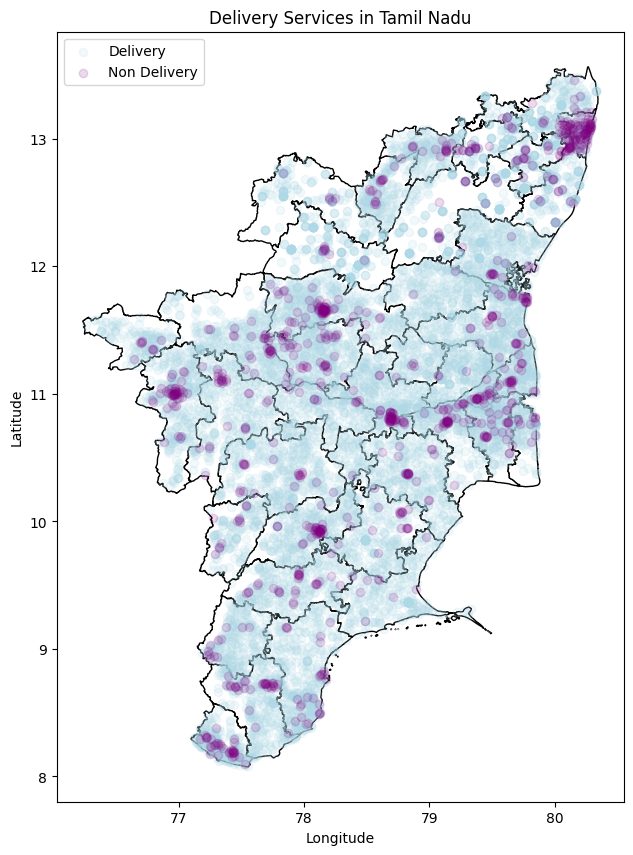

In [52]:
# Plot delivery services distribution.
fig, ax = plt.subplots(figsize=(8, 10))
tamilnadu.plot(ax=ax, color='white', edgecolor='black')

x_del=[p_x[i] for i in range(len(p_x)) if delivery[i]=='Delivery']
y_del=[p_y[i] for i in range(len(p_y)) if delivery[i]=='Delivery']

x_ndel=[p_x[i] for i in range(len(p_x)) if delivery[i]=='Non Delivery']
y_ndel=[p_y[i] for i in range(len(p_y)) if delivery[i]=='Non Delivery']

plt.scatter(x_del, y_del, c='lightblue', alpha=0.15, label='Delivery')
plt.scatter(x_ndel, y_ndel, c='purple', alpha=0.15, label='Non Delivery')

plt.legend()
plt.title('Delivery Services in Tamil Nadu')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

The above map gives us insight with regards to the delivery facilities available in places within Tamil Nadu. The non-availability of delivery serives seems to be quite few and scattered. However, notably, the non-availability of delivery services around Chennai seems to be higher that expected. One possible explanation could be that a disproportionate amount of data was collected around Chennai.

## <font color=blue>4. Results</font>

*   The data seems to represent data of the post services available in different areas and the offices present.
*   Several datapoints are incorrect, including point from within Tamilnadu but with coordinates lying outside.
*   The data analysis results align with the fact that Chennai is the capital.
*   The distribution of various pincode value ranges was understood.

Importantly, the clustering resulted via k-clustering using the optimal value of k=4 signifies the regions of Tamilnadu. On plotting, both the map distributions were very similar giving us insight regarding the relevance of the k-clustering (k=4).

### References
1. TamilNadu Shapefile: https://github.com/karthi209/tamilnadu-state-shapefile

2. Post Offices Data (of Tamilnadu, in particular): https://www.indiapost.gov.in/VAS/pages/pmodashboard/distributionofpostoffices.aspx
